In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import re
import os

sns.set_style("whitegrid")
sns.set_palette("deep")

# Configure Matplotlib to use LaTeX for rendering
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use serif font in conjunction with LaTeX
    "text.latex.preamble": r"\usepackage{times}",
    })

In [78]:
def extract_title_from_pattern(pattern):
    match = re.search(r'epochs(.*?)(corr|oriCorr)', pattern)
    model = re.search(r'pythia-(.*?)_s', pattern).group(1)
    title = 'Model=Pythia-' + model + '; '
    if match:
        params_str = match.group(1)
        params = params_str.split('_')
        params = [x for x in params if x !='']
        for i in range(len(params)):
            if params[i] == 'lr':
                title += 'lr=' + params[i+1] + '; '
            if params[i] == 'policy':
                title += 'policy=' + params[i+1]
    title = title[:-2]
    return title

In [79]:
def get_policy(x):
    if 'policy' in x:
        return re.search(r'policy_(.*?)_', x).group(1)
    return re.search(r'pythia-(.*?)_s', x).group(1)

In [226]:
def error_bars_plot(pattern, setting='sd', ylim=(0, 0.2), title=True, epochs=50, metrics=['epoch_losses', 'correlations'], to_smooth={}, savefig=False):
    # Get all matching files
    file_paths = glob.glob(pattern)
    runs = [pd.read_json(file_path).head(epochs) for file_path in file_paths]

    print("Number of runs:", len(runs))

    combined_df = pd.concat(runs, keys=range(len(runs)))
    combined_df = combined_df.reset_index(level=0, drop=True)
    combined_df = combined_df.rename_axis('epoch').reset_index()

    # Create a figure with subplots based on the number of metrics
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 8)) # fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 12))
    if title:
        fig.suptitle(extract_title_from_pattern(pattern), fontsize=38)

    # Plot each metric in its respective subplot
    for ax, metric in zip(axes, metrics):
        if metric in list(to_smooth.keys()):
            sns.lineplot(data=combined_df.ewm(alpha=to_smooth[metric], adjust=False).mean(), x="epoch", y=metric, ax=ax, marker=None, errorbar=setting, linewidth=4)
        else:
            sns.lineplot(data=combined_df, x="epoch", y=metric, ax=ax, marker=None, errorbar=setting, linewidth=4)
        ax.set_title(f"{metric.replace('_', ' ').title()} Across Runs", fontsize=36)
        ax.set_xlabel("Epoch", fontsize=32)
        ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=32)
        ax.tick_params(axis='both', which='major', labelsize=26)
        if ylim and metric is not 'epoch_losses':
            ax.set_ylim(ylim)

    # Adjust layout and display the plot
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.1)
    if savefig:
        plt.savefig(f'plots/irl/{savefig}.png', dpi=1200, transparent=False)
    plt.show()

def error_bars_plot_multi(df, setting='sd', ylim=(0, 0.2), savefig=False):
    # Extract losses and correlations into a long format suitable for seaborn
    combined_df = pd.DataFrame()

    for idx, row in df.iterrows():
        temp_df = pd.DataFrame({
            'epoch': range(len(row['all_epoch_losses'])),
            'epoch_losses': row['all_epoch_losses'],
            'correlations': row['all_correlations']
        })
        temp_df['run'] = idx
        combined_df = pd.concat([combined_df, temp_df])

    combined_df = combined_df.reset_index(drop=True)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    fig.suptitle("Losses and Correlations Across Epochs", fontsize=38)

    # Plot epoch losses
    sns.lineplot(data=combined_df, x="epoch", y="epoch_losses", ax=ax1, marker='o', errorbar=setting)
    ax1.set_title("Epoch Losses Across Runs", fontsize=36)
    ax1.set_xlabel("Epoch", fontsize=32)
    ax1.set_ylabel("Loss", fontsize=32)

    # Plot correlations
    sns.lineplot(data=combined_df, x="epoch", y="correlations", ax=ax2, marker='o', errorbar=setting)
    ax2.set_title("Correlations Across Runs", fontsize=36)
    ax2.set_xlabel("Epoch", fontsize=32)
    ax2.set_ylabel("Correlation", fontsize=32)

    if ylim:
        ax2.set_ylim(ylim)

    # Adjust layout and display the plot
    plt.tight_layout()
    if savefig:
        plt.savefig(f'plots/irl/{savefig}.png', dpi=600, transparent=True)
    plt.show()

<>:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_84745/1832931564.py:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if ylim and metric is not 'epoch_losses':


In [196]:
def error_bars_comparison_plot(pattern, epochs, setting='sd', param='lr', metrics=['epoch_losses', 'correlations'], savefig=False):
    # Get all matching files
    file_paths = glob.glob(pattern)
    runs = []
    for file_path in file_paths:
        run_df = pd.read_json(file_path).head(epochs)
        run_df[param] = float(re.search(rf'{param}_(.*?)_', file_path).group(1))
        runs.append(run_df)
    
    print("Number of runs:", len(runs))
    
    combined_df = pd.concat(runs, keys=range(len(runs)))
    combined_df = combined_df.reset_index(level=0, drop=True)
    combined_df = combined_df.rename_axis('epoch').reset_index()

    # Create a figure with subplots based on the number of metrics
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 7))
    fig.suptitle(extract_title_from_pattern(pattern), fontsize=38)

    # Plot each metric in its respective subplot
    for ax, metric in zip(axes, metrics):
        sns.lineplot(data=combined_df, x="epoch", y=metric, hue=param, style=param, ax=ax, errorbar=setting, palette=sns.color_palette("hls", n_colors=len(combined_df[param].unique())))
        ax.set_title(f"{metric.replace('_', ' ').title()} Across Runs", fontsize=36)
        ax.set_xlabel("Epoch", fontsize=32)
        ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=32)
        ax.tick_params(axis='both', which='major', labelsize=26)
        if metric == 'epoch_losses':
            ax.legend(title='', fontsize=22)
        else:
            ax.get_legend().remove()

    # Adjust layout and display the plot
    plt.tight_layout()
    if savefig:
        plt.savefig(f'plots/irl/{savefig}.png', dpi=600, transparent=True)
    plt.show()

# Single IRL

## 70m Model: pythia-70m-roberta-lr_3e6-kl_0035-steps_600-rlhf-model

### 10 epochs; lr 1e-4; sample size 100

/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_67586/921408896.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=combined_df, x="epoch", y="epoch_losses", ax=ax1, marker='o', ci=setting)
/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_67586/921408896.py:56: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=combined_df, x="epoch", y="correlations", ax=ax2, marker='o', ci=setting)


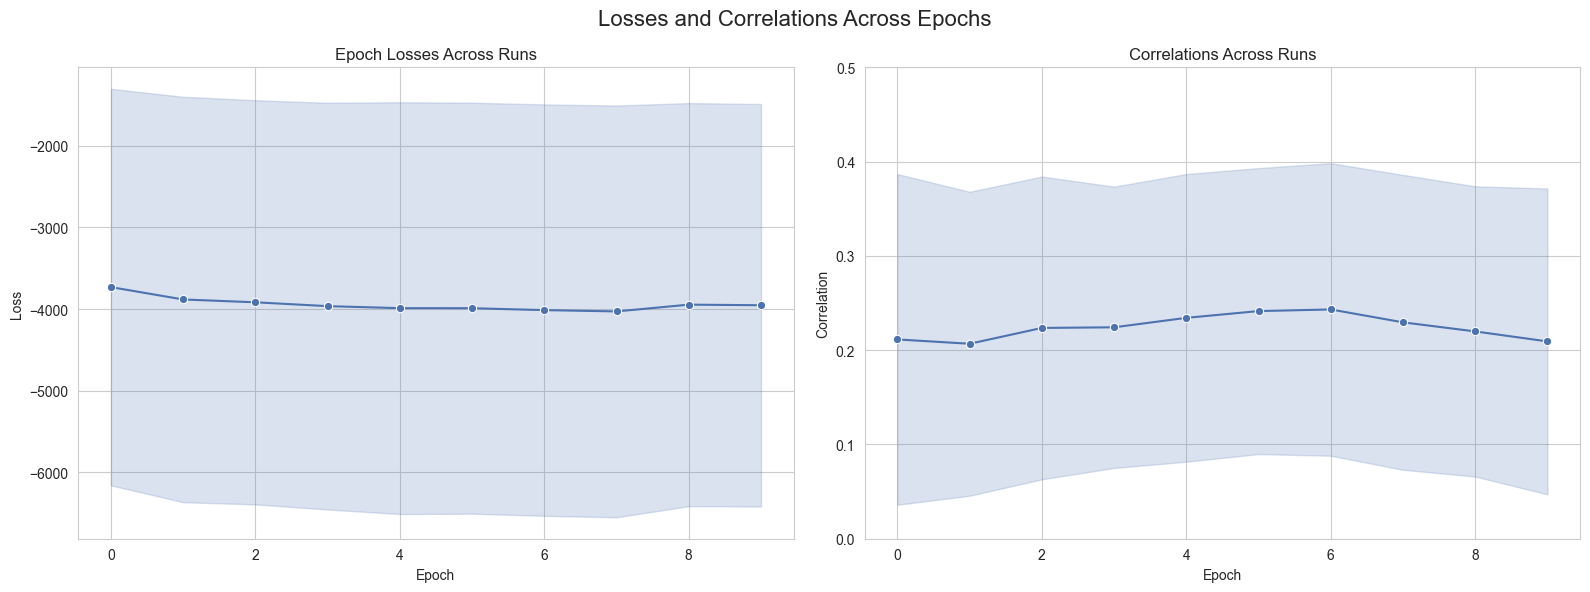

In [94]:
df = pd.read_json("results/irl/loss_corr/results_10_epochs_lr_0.0001_jaredjoss-jigsaw-long-2000_70m_ss_100.json")

error_bars_plot_multi(df)

### 15 epochs; lr 1e-4; sample size 100

Number of runs: 19


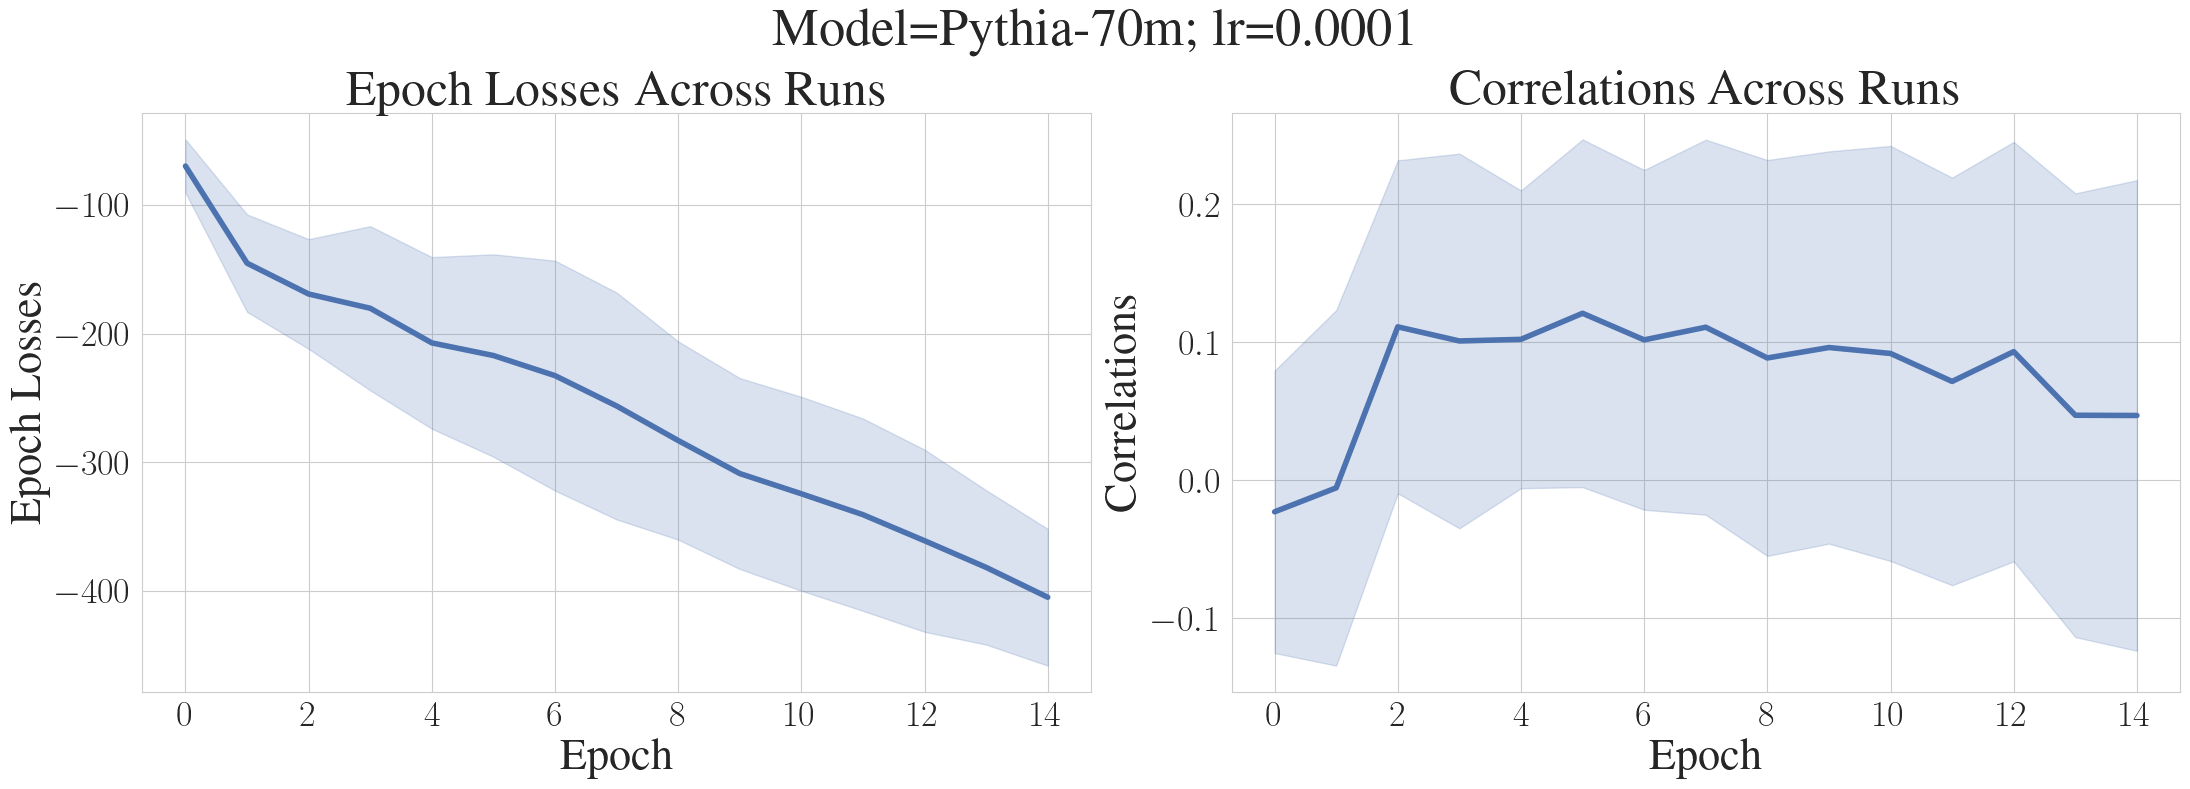

In [197]:
pattern = "results/irl/loss_corr/results_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier_15_epochs_lr_0.0001_70m_ss_100_corr*.json"

error_bars_plot(pattern, ylim=None, setting='sd')

### 30 epochs; lr 1e-4; sample size 100, Corr - original dataset

Number of runs: 19


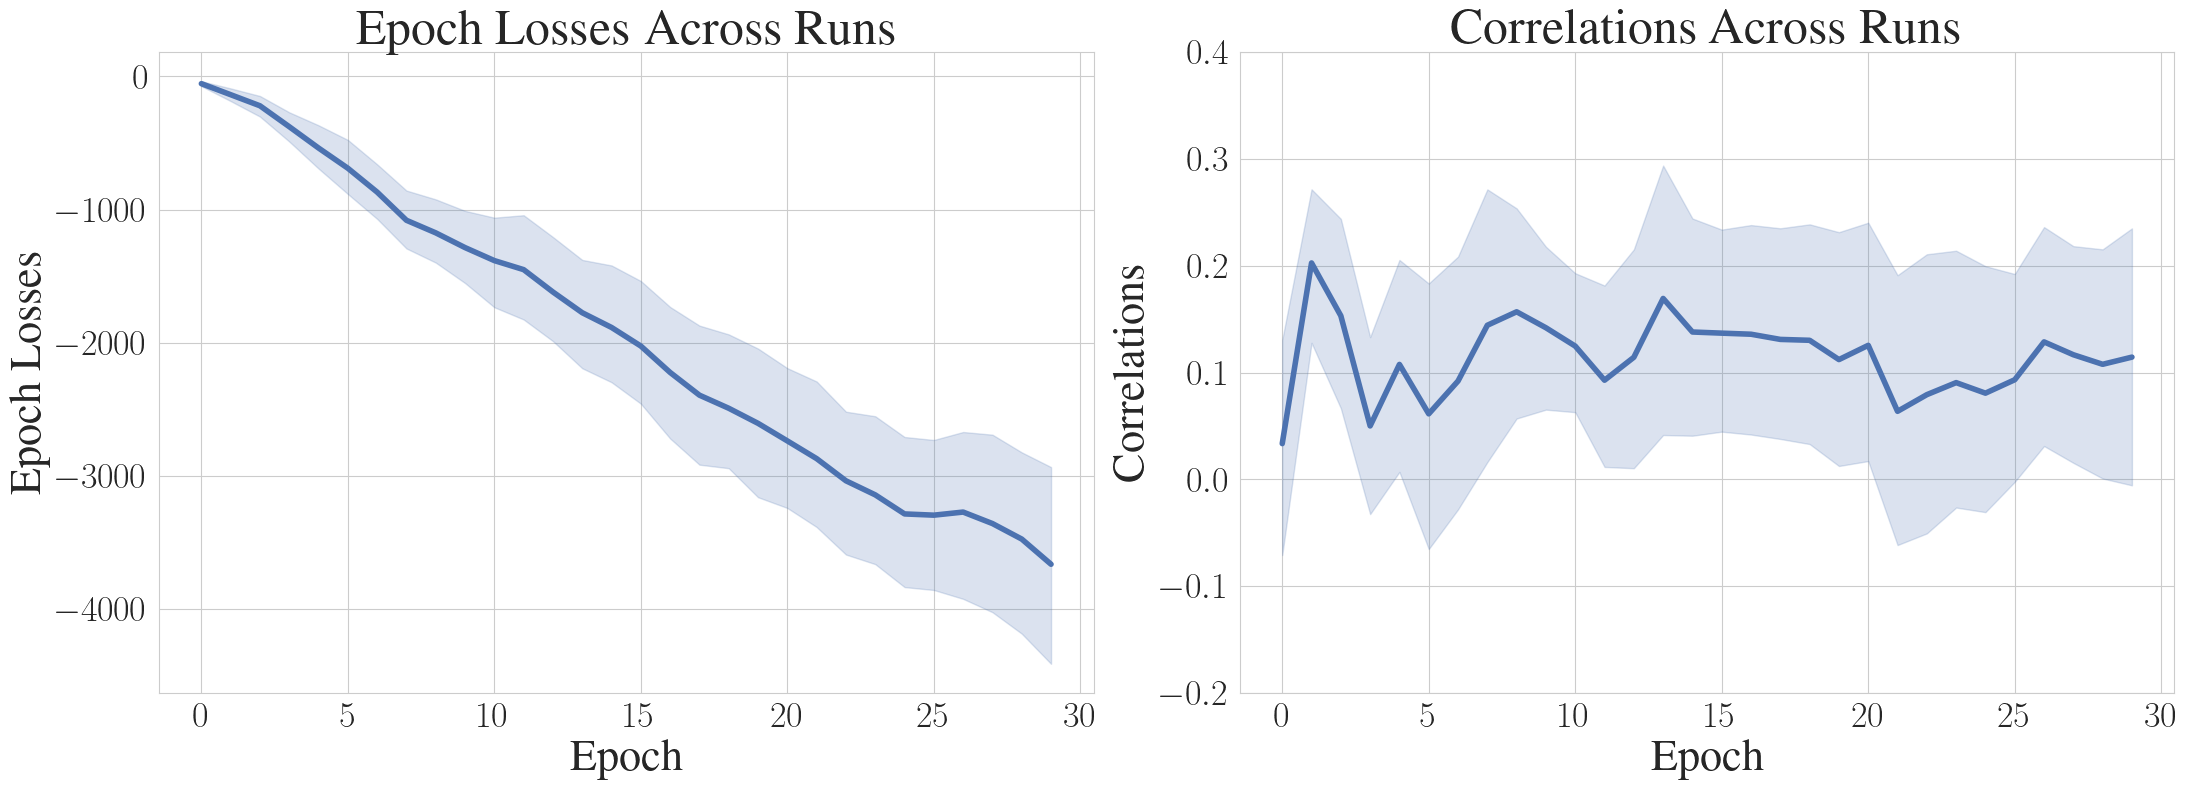

Number of runs: 19


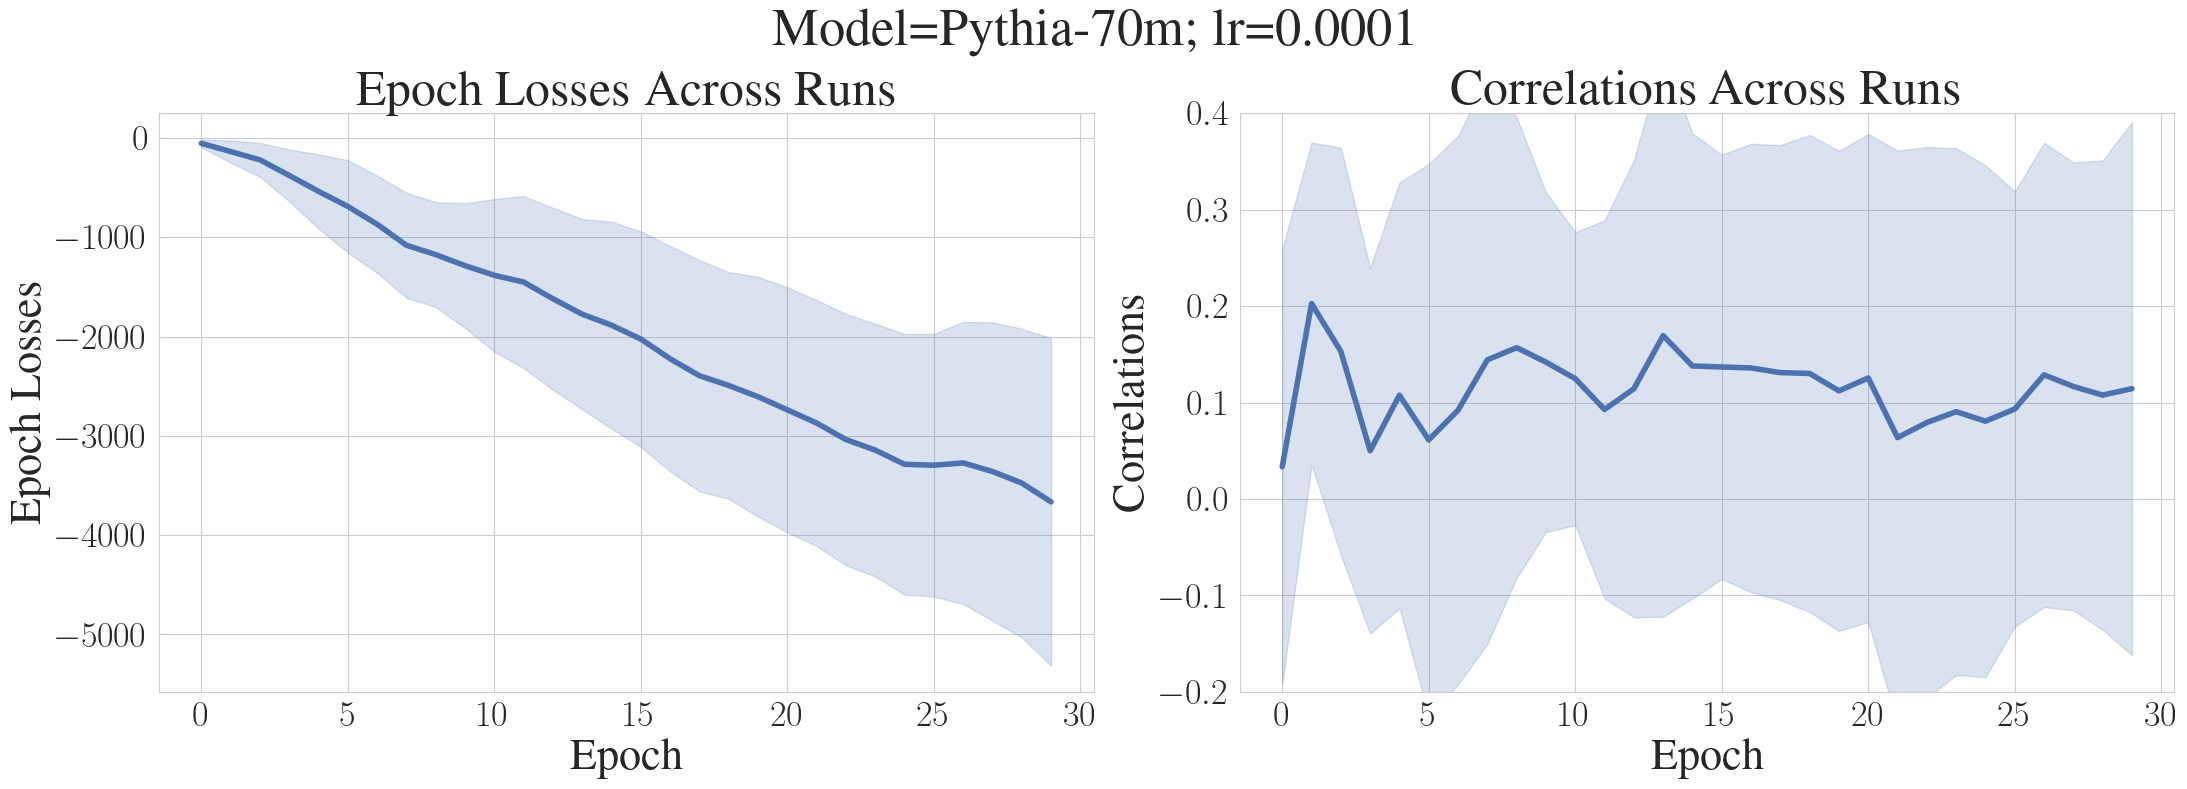

In [200]:
pattern = "results/irl/loss_corr/results_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier__30_epochs_lr_0.0001_jaredjoss-jigsaw-long-2000_70m_ss_100_oriCorr_*.json"

error_bars_plot(pattern, ylim=(-0.2, 0.4), setting='ci', epochs=300, title=False, savefig=False) # '70m_loss_corr_lr_0.0001'
error_bars_plot(pattern, ylim=(-0.2, 0.4), setting='sd', savefig=False) # '70m_loss_corr_lr_0.0001'

### 15 epochs; lr 1e-4; sample size 100, policy: 410m

Number of runs: 20


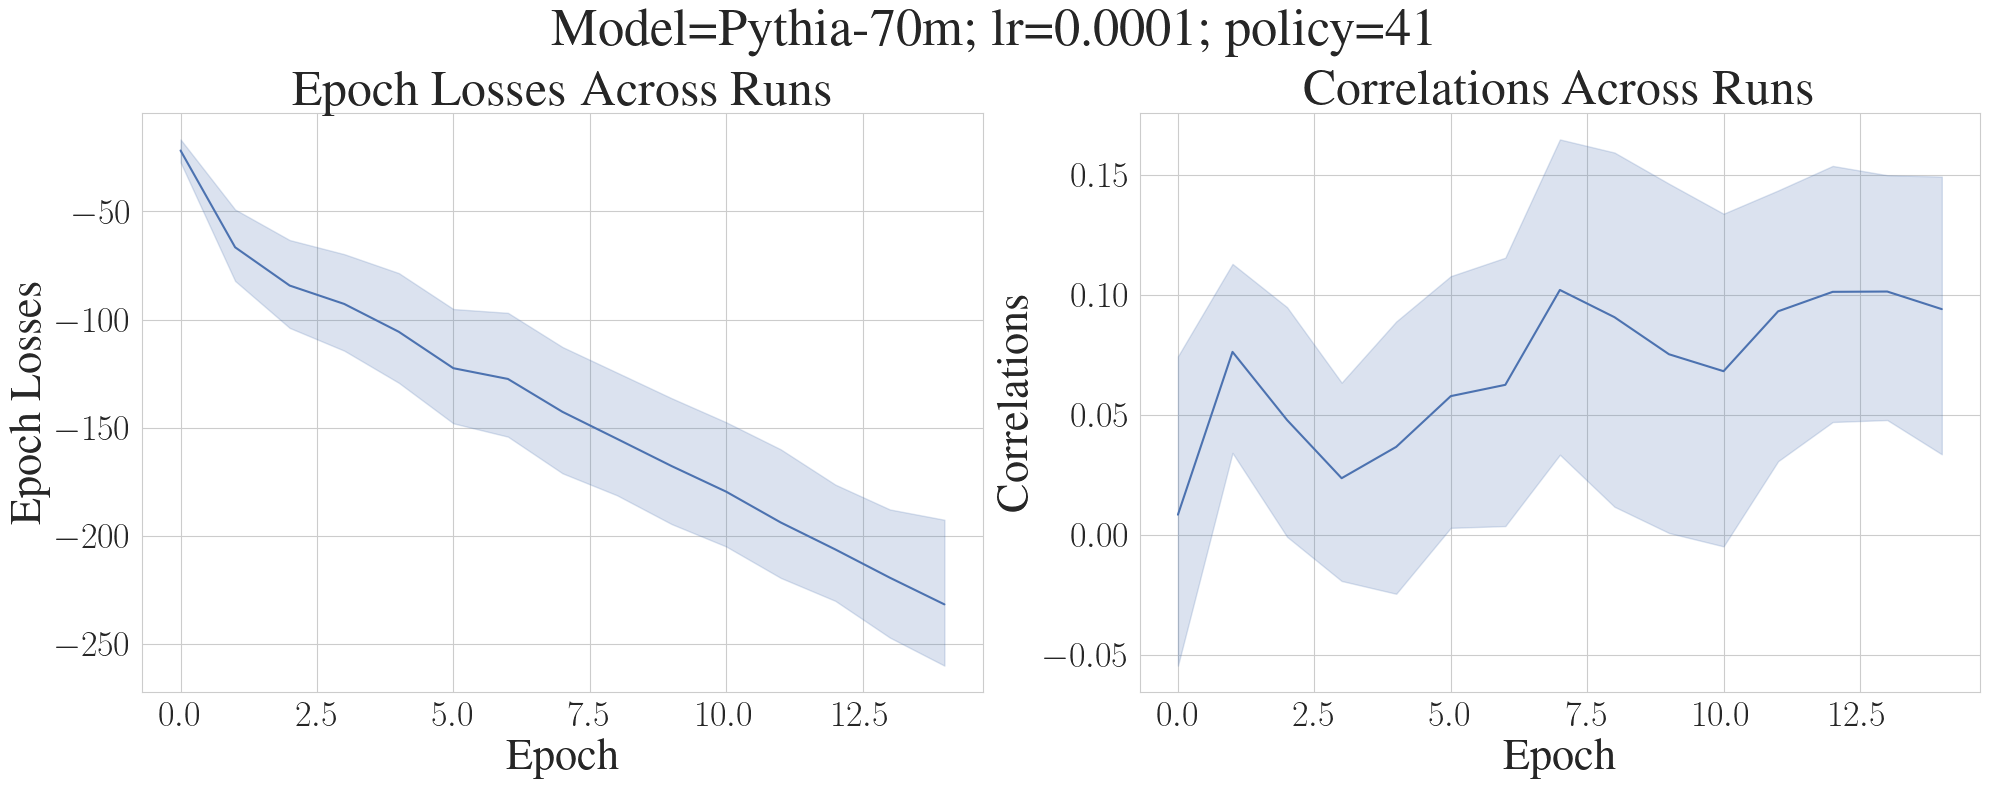

In [84]:
pattern = "results/irl/loss_corr/results_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier_15_epochs_lr_0.0001_70m_ss_100_policy_410m_corr*.json"

error_bars_plot(pattern, ylim=None, setting='ci')

### 30 epochs; lr 1e-4; sample size 100, policy: 410m

Number of runs: 39


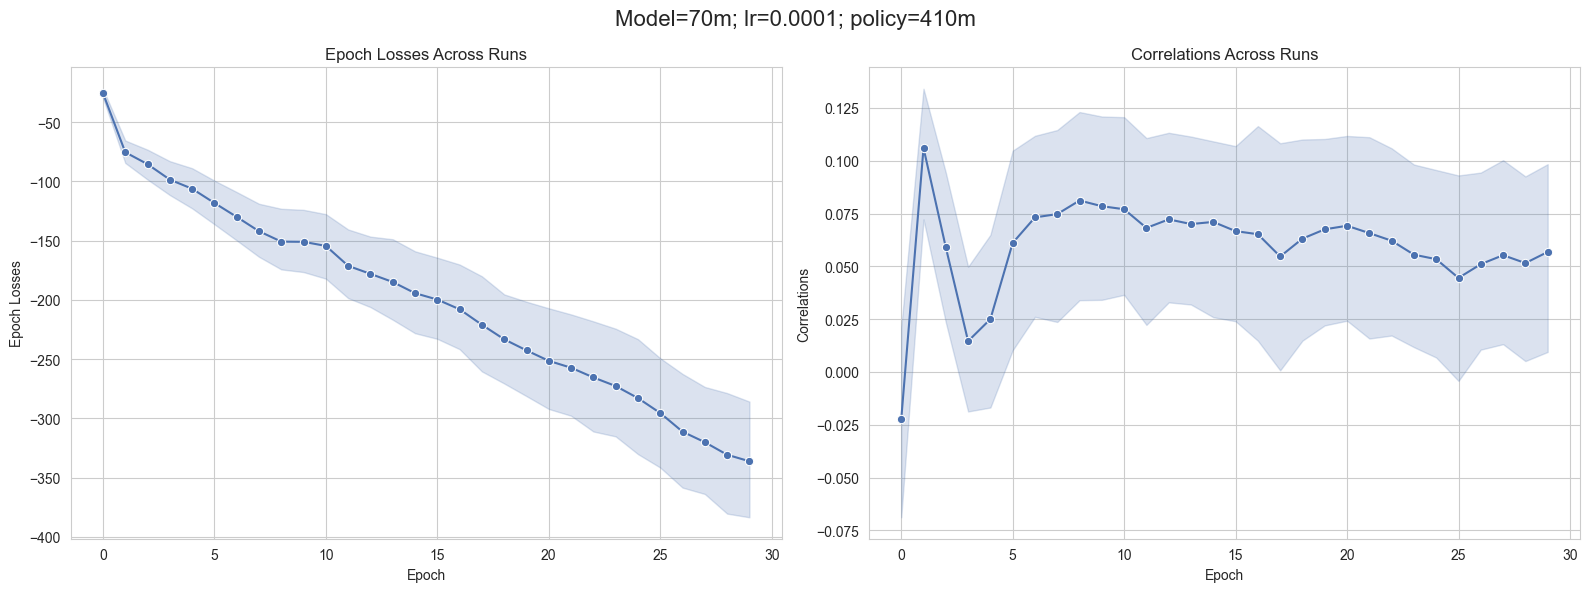

In [70]:
pattern = "results/irl/loss_corr/results_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier_30_epochs_lr_0.0001_70m_ss_100_policy_410m_corr*.json"

error_bars_plot(pattern, ylim=None, setting='ci')

### 30 epochs; lr 1e-5; sample size 100, policy: 410m

Number of runs: 20


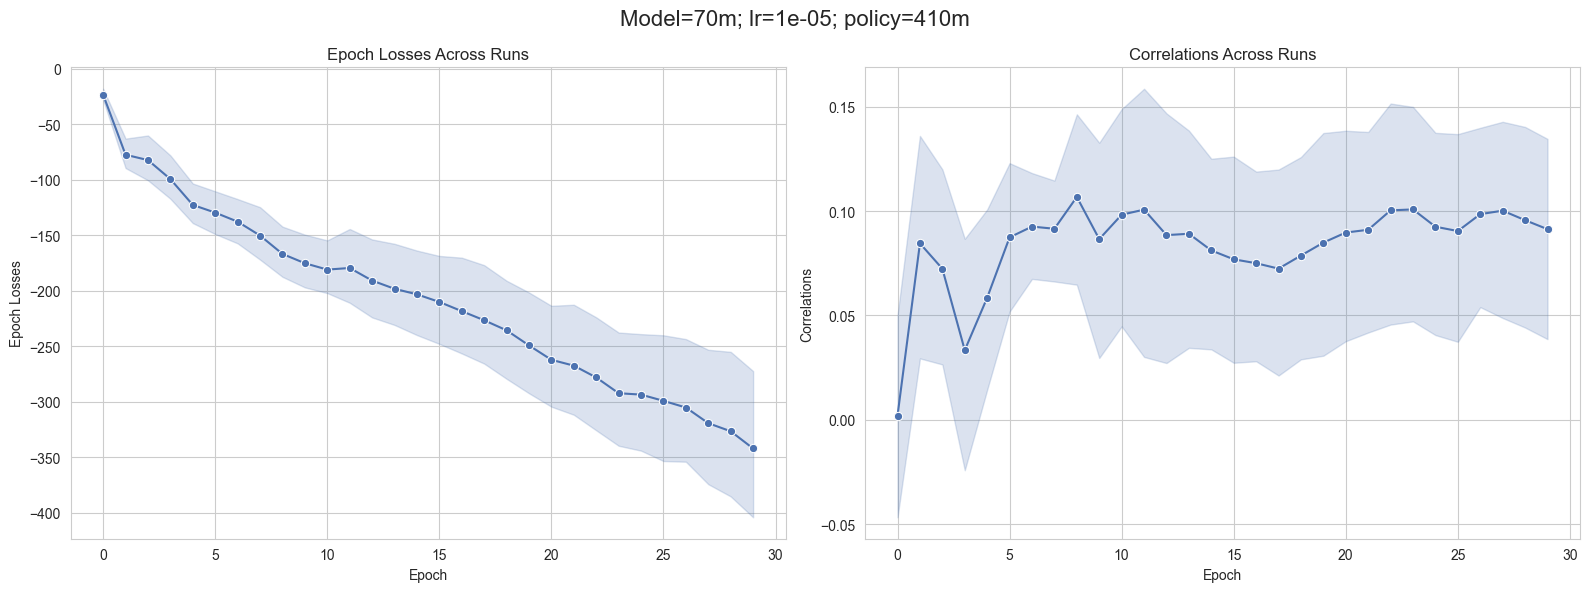

In [71]:
pattern = "results/irl/loss_corr/results_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier_30_epochs_lr_1e-05_70m_ss_100_policy_410m_corr*.json"

error_bars_plot(pattern, ylim=None, setting='ci')

#### Loss
- decreases consistently from run to run
- error bars are relatively large indicating variability in performance across runs


#### Correlation
- no consistent increase or decrease
- huge error bars which shows huge variability from run-to-run
    - inconsistent runs

### 15 epochs; lr 1e-5; sample size 100

Number of runs: 28


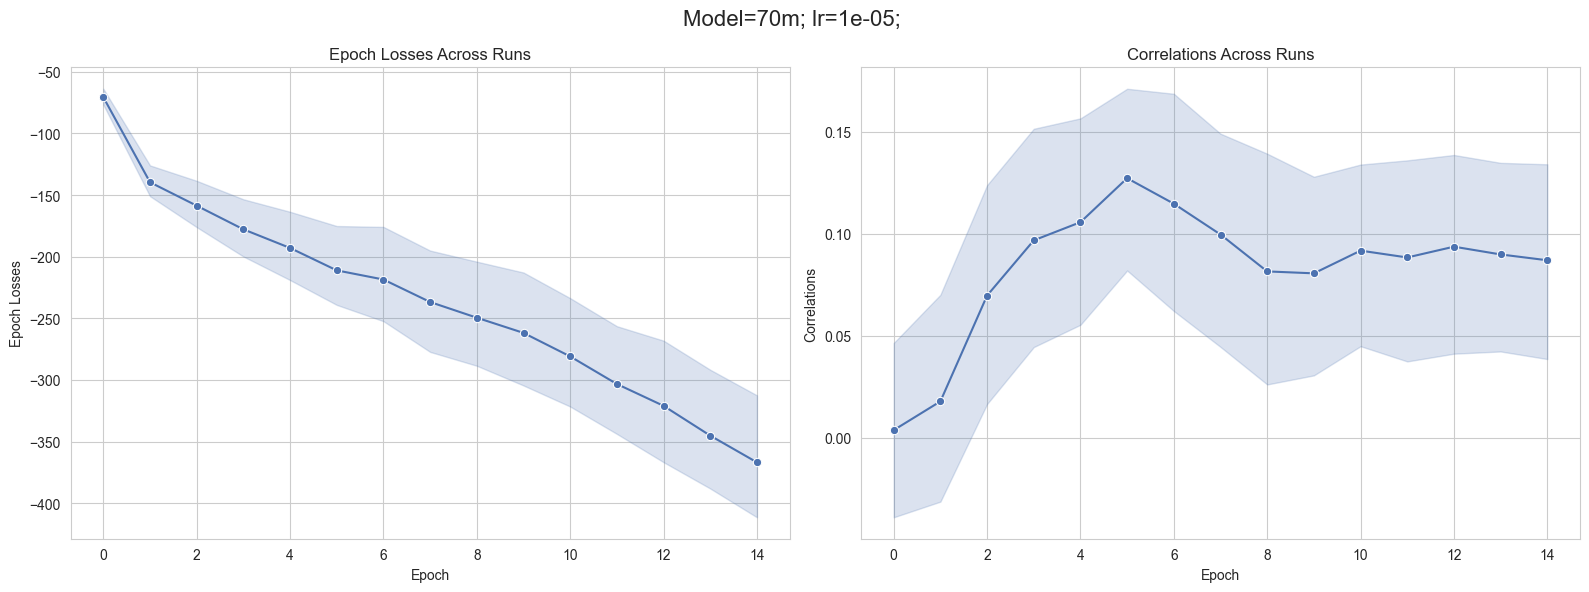

In [72]:
pattern = "results/irl/loss_corr/results_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier_15_epochs_lr_1e-05_70m_ss_100_corr*.json"

error_bars_plot(pattern, ylim=None, setting='ci')

### Different Lr's

Number of runs: 204


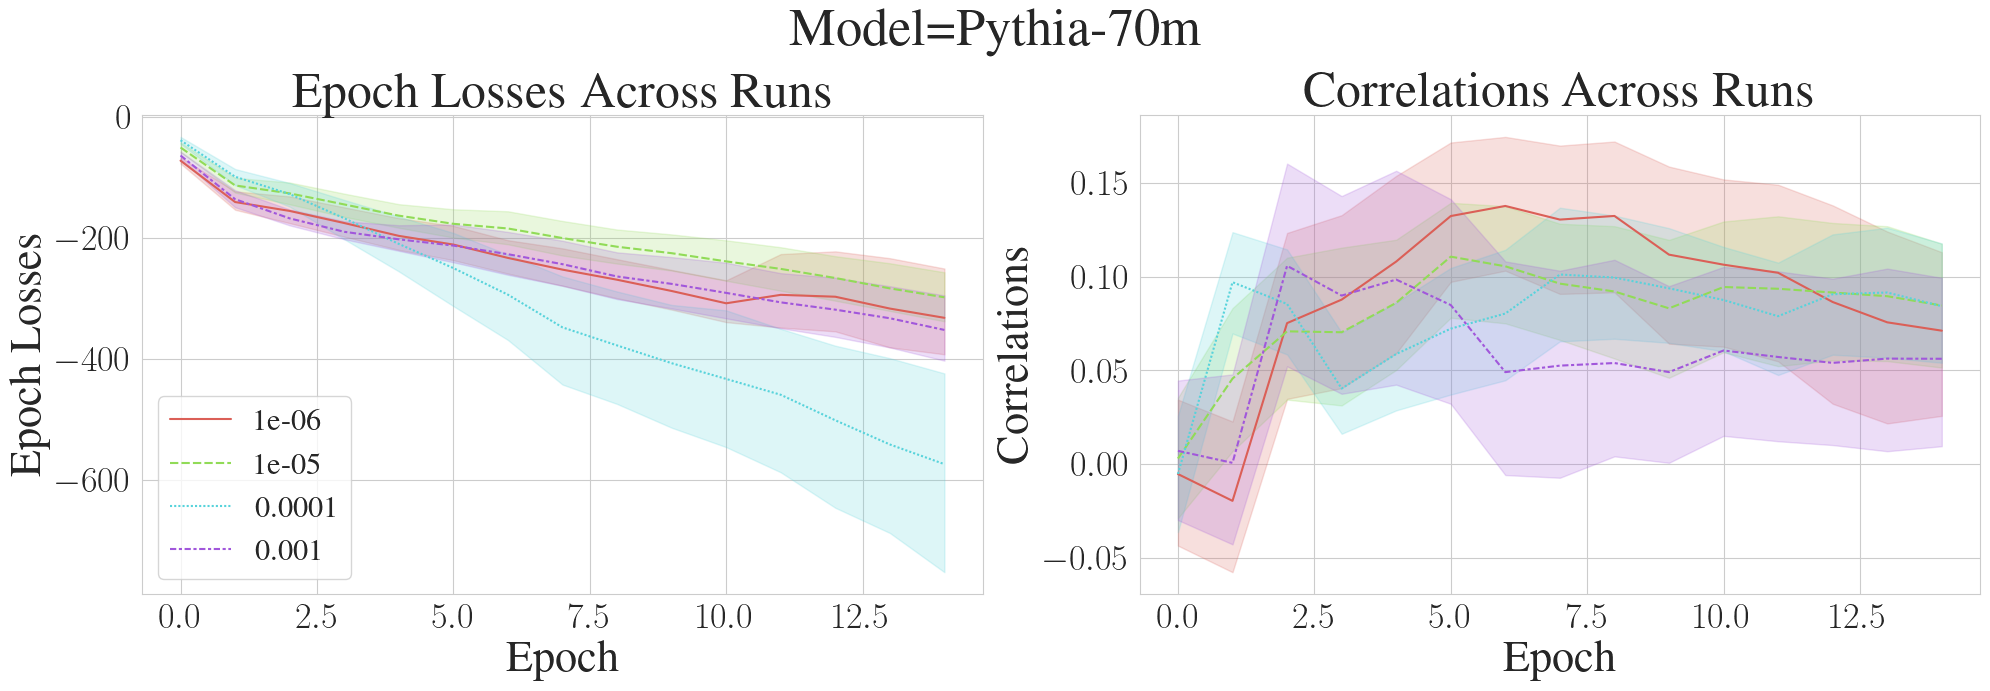

In [106]:
pattern = "results/irl/loss_corr/results_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier_*_epochs_lr_*_70m_ss_100_*.json"

error_bars_comparison_plot(pattern, epochs=15, setting='ci', param='lr', savefig='70m_loss_corr_lr_comparison')

## 410m Model: pythia-410m-roberta-lr_8e7-kl_01-steps_12000-rlhf-model

### 15 epochs; lr 1e-4; sample size 200

Number of runs: 20


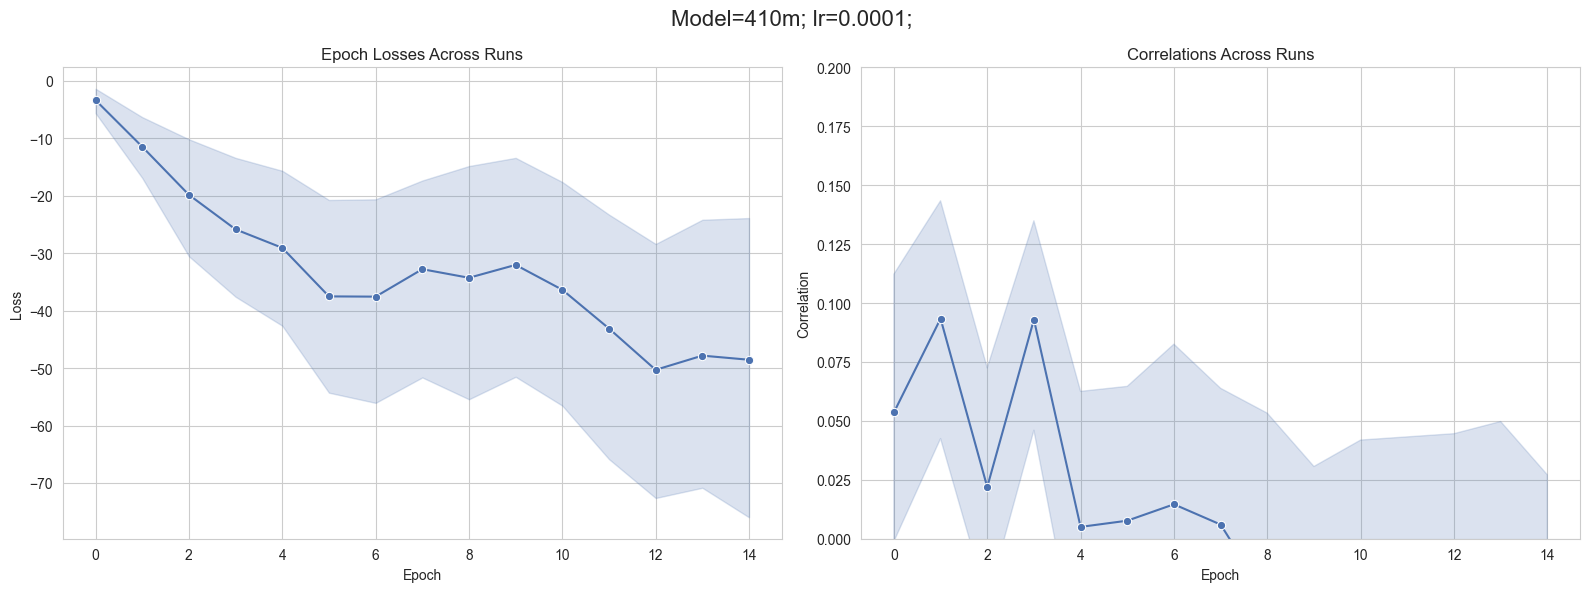

In [13]:
pattern = "results/irl/loss_corr/results_EleutherAI-pythia-410m_s-nlp-roberta_toxicity_classifier_15_epochs_lr_0.0001_410m_ss_200_corr*.json"

error_bars_plot(pattern, setting='ci')

### 15 epochs; lr 1e-5; sample size 200

Number of runs: 20


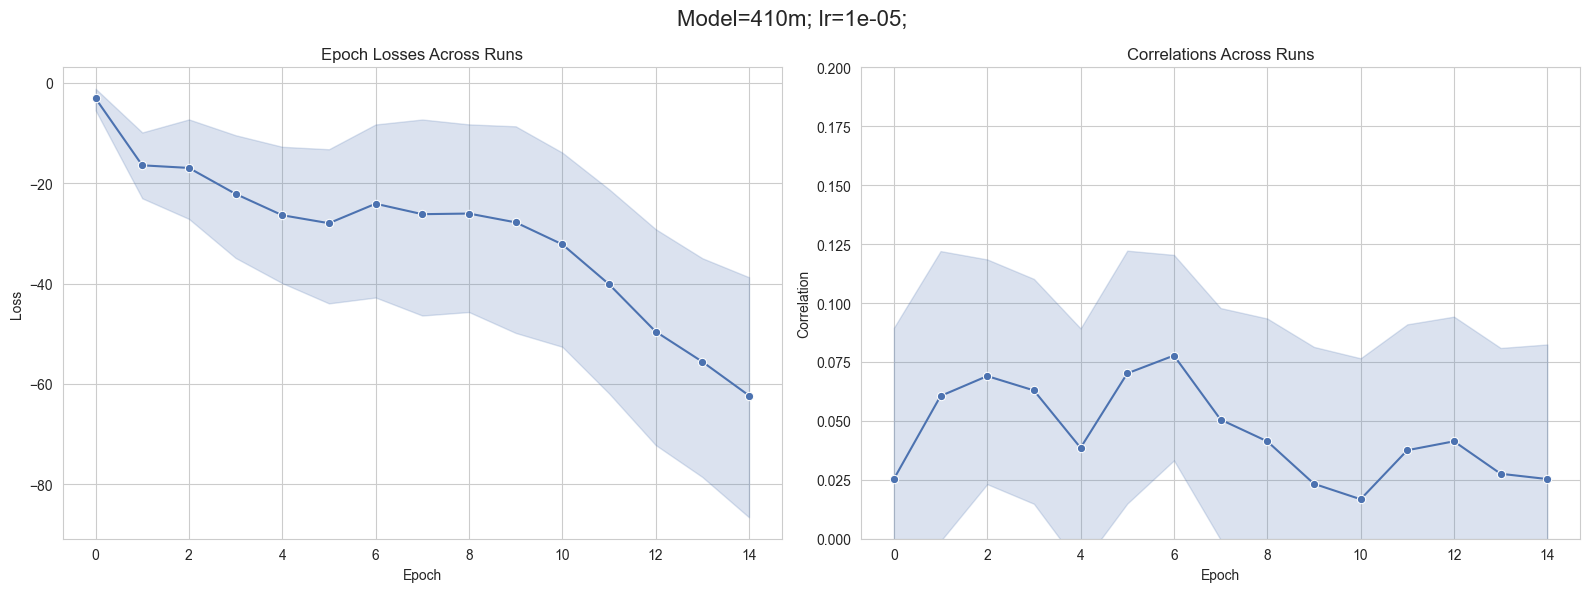

In [14]:
pattern = "results/irl/loss_corr/results_EleutherAI-pythia-410m_s-nlp-roberta_toxicity_classifier_15_epochs_lr_1e-05_410m_ss_200_corr*.json"

error_bars_plot(pattern, setting='ci')

### 15 epochs; lr 1e-6; sample size 200

Number of runs: 19


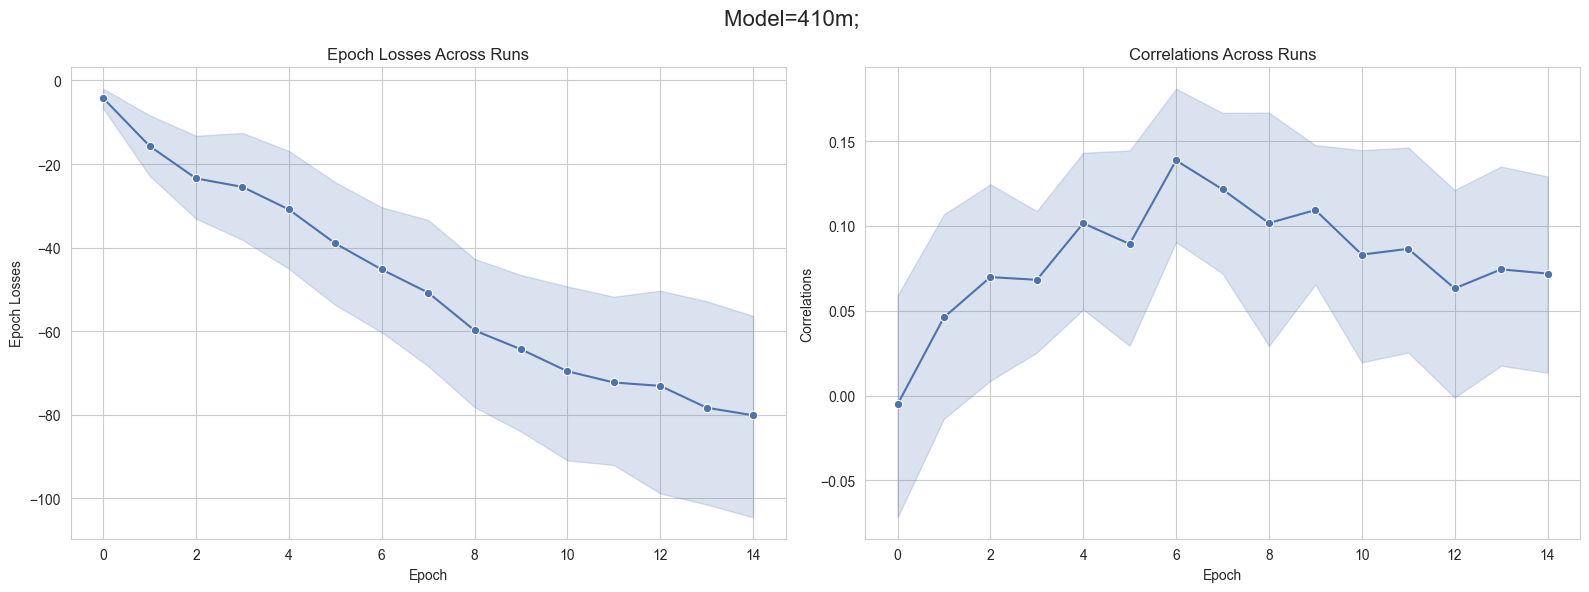

In [73]:
pattern = "results/irl/loss_corr/results_EleutherAI-pythia-410m_s-nlp-roberta_toxicity_classifier_15_epochs_lr_1e-06_410m_ss_200_*.json"

error_bars_plot(pattern, ylim=None, setting='ci')

### 15 epochs; lr 1e-7; sample size 200

Number of runs: 20


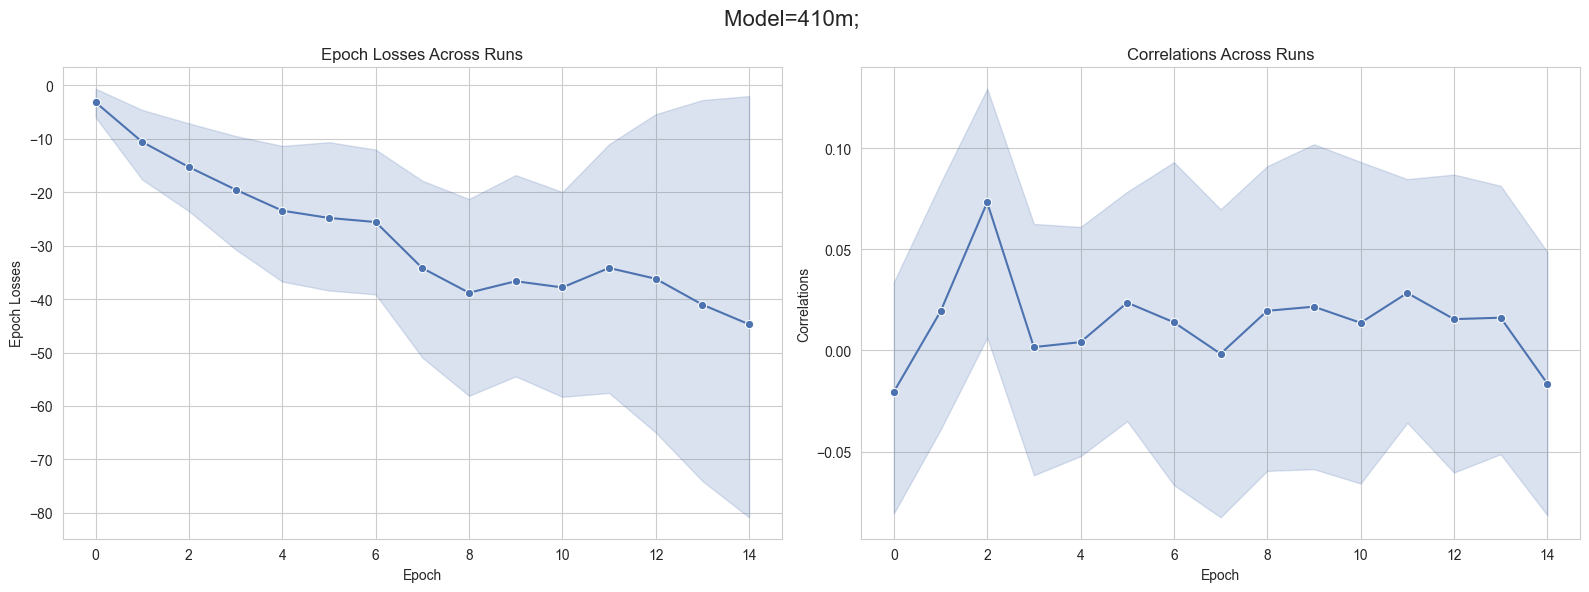

In [74]:
pattern = "results/irl/loss_corr/results_EleutherAI-pythia-410m_s-nlp-roberta_toxicity_classifier_15_epochs_lr_1e-07_410m_ss_200_*.json"

error_bars_plot(pattern, ylim=None, setting='ci')

### Different LRs

Number of runs: 79


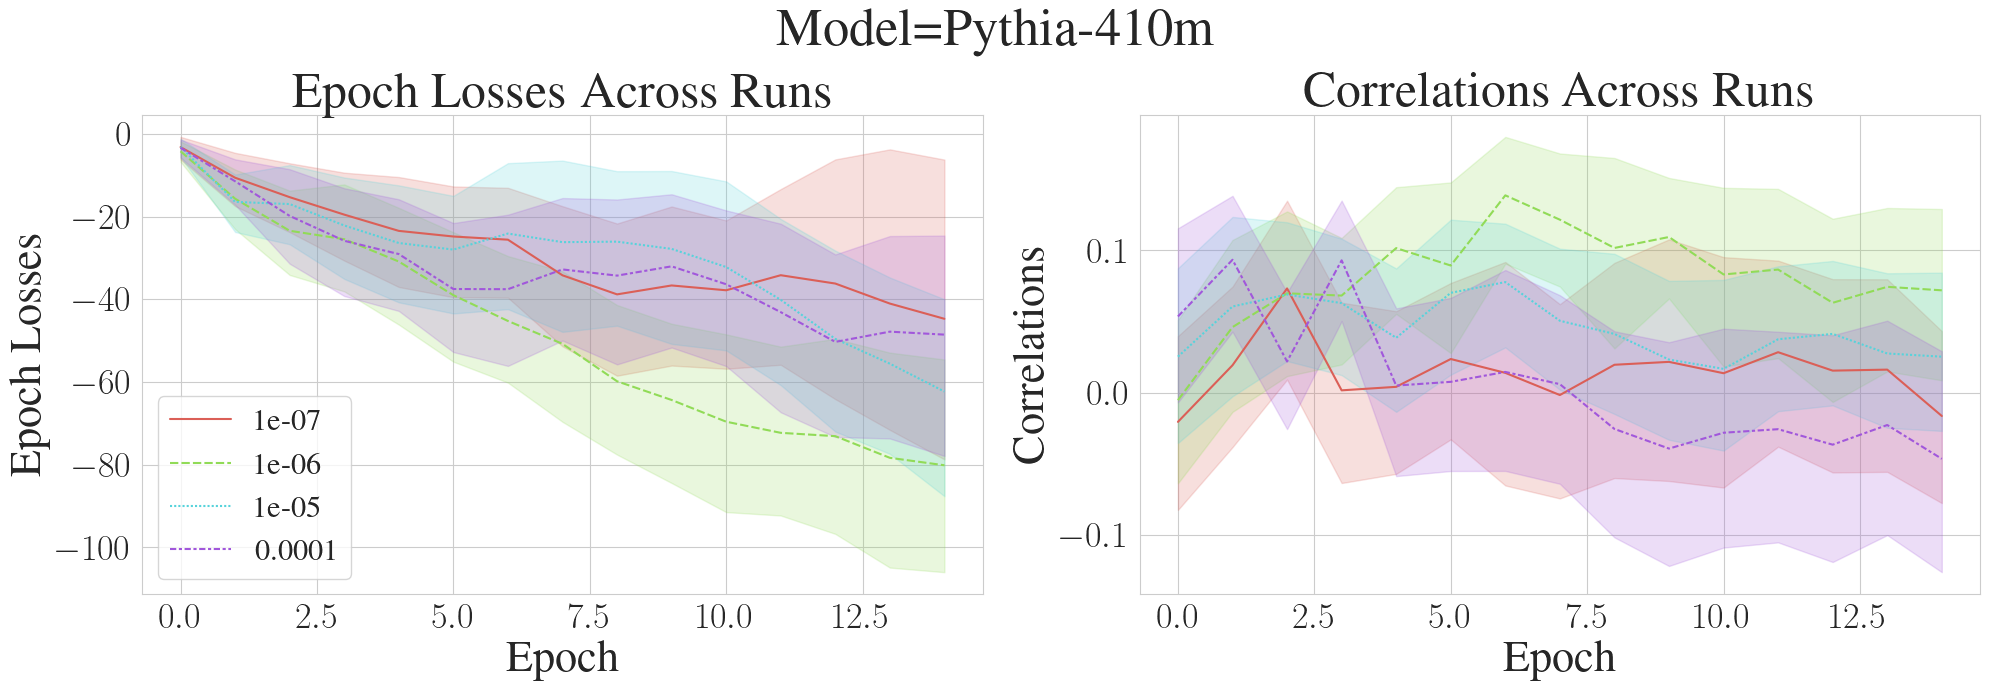

In [108]:
pattern = "results/irl/loss_corr/results_EleutherAI-pythia-410m_s-nlp-roberta_toxicity_classifier_15_epochs_lr_*_410m_ss_200_*.json"

error_bars_comparison_plot(pattern, epochs=15, setting='ci', param='lr', savefig='410m_loss_corr_lr_comparison')

## Overall

In [229]:
pattern = "results/irl/loss_corr/results_EleutherAI-pythia*"

file_paths = glob.glob(pattern)
runs = []
for file_path in file_paths:
    run_df = pd.read_json(file_path)
    run_df['path'] = file_path
    run_df['lr'] = float(re.search(r'lr_(.*?)_', file_path).group(1))
    run_df['model'] = re.search(r'pythia-(.*?)_', file_path).group(1)
    runs.append(run_df)

print("Number of runs:", len(runs))

combined_df = pd.concat(runs, keys=range(len(runs)))
combined_df = combined_df.reset_index(level=0, drop=True)
combined_df = combined_df.rename_axis('epoch').reset_index()

combined_df

Number of runs: 283


,epoch,epoch_losses,correlations,path,lr,model
0,0,-23.692610,0.127700,results/irl/loss_corr/results_EleutherAI-pythi...,0.000100,70m
1,1,-89.966510,0.119541,results/irl/loss_corr/results_EleutherAI-pythi...,0.000100,70m
2,2,-99.820522,-0.253967,results/irl/loss_corr/results_EleutherAI-pythi...,0.000100,70m
3,3,-88.339238,-0.209469,results/irl/loss_corr/results_EleutherAI-pythi...,0.000100,70m
4,4,-80.155782,0.040910,results/irl/loss_corr/results_EleutherAI-pythi...,0.000100,70m
...,...,...,...,...,...,...
5410,10,-128.506669,0.193067,results/irl/loss_corr/results_EleutherAI-pythi...,0.000001,410m
5411,11,-136.571055,0.185085,results/irl/loss_corr/results_EleutherAI-pythi...,0.000001,410m
5412,12,-144.497367,0.177480,results/irl/loss_corr/results_EleutherAI-pythi...,0.000001,410m
5413,13,-154.283869,0.199824,results/irl/loss_corr/results_EleutherAI-pythi...,0.000001,410m


In [230]:
combined_df['correlations'].describe()

count    5415.000000
mean        0.068345
std         0.153329
min        -0.747688
25%        -0.031450
50%         0.080009
75%         0.174423
max         0.645260
Name: correlations, dtype: float64

In [231]:
# analysis of all runs
analysis_df = combined_df.groupby('path').agg(
    max_correlation=('correlations', 'max'),
    mean_correlation=('correlations', 'mean')
).reset_index().sort_values(by='mean_correlation', ascending=False)
analysis_df['lr'] = analysis_df['path'].apply(lambda x: float(re.search(r'lr_(.*?)_', x).group(1)))
analysis_df['model'] = analysis_df['path'].apply(lambda x: re.search(r'pythia-(.*?)_', x).group(1))
analysis_df['policy'] = analysis_df['path'].apply(get_policy)

analysis_df

,path,max_correlation,mean_correlation,lr,model,policy
282,results/irl/loss_corr/results_EleutherAI-pythi...,0.628052,0.428311,0.00010,70m,70m
279,results/irl/loss_corr/results_EleutherAI-pythi...,0.617480,0.361000,0.00010,70m,70m
280,results/irl/loss_corr/results_EleutherAI-pythi...,0.538067,0.351591,0.00010,70m,70m
175,results/irl/loss_corr/results_EleutherAI-pythi...,0.378009,0.284106,0.00001,70m,70m
171,results/irl/loss_corr/results_EleutherAI-pythi...,0.315347,0.239504,0.00001,70m,70m
...,...,...,...,...,...,...
214,results/irl/loss_corr/results_EleutherAI-pythi...,0.128602,-0.162185,0.00010,70m,410m
101,results/irl/loss_corr/results_EleutherAI-pythi...,0.151474,-0.168583,0.00010,70m,410m
127,results/irl/loss_corr/results_EleutherAI-pythi...,0.218861,-0.182793,0.00100,70m,70m
9,results/irl/loss_corr/results_EleutherAI-pythi...,0.252693,-0.198122,0.00010,410m,410m


In [232]:
# find all combinations of lr and model that have the highest mean correlation
analysis_df.groupby(['lr', 'model'])['mean_correlation'].max().reset_index()

,lr,model,mean_correlation
0,1.000000e-07,410m,0.184563
1,1.000000e-06,410m,0.189636
2,1.000000e-06,70m,0.238671
3,1.000000e-05,410m,0.203749
4,1.000000e-05,70m,0.284106
5,1.000000e-04,410m,0.121838
6,1.000000e-04,70m,0.428311
7,1.000000e-03,70m,0.227363


In [115]:
# find specific combination
model = '410m'
policy = '410m'

best_df = analysis_df.sort_values(by='max_correlation', ascending=False).reset_index(drop=True)
best_df[(best_df['model'] == model) & (best_df['policy'] == policy)].head(1)

,path,max_correlation,mean_correlation,lr,model,policy
18,results/irl/loss_corr/results_EleutherAI-pythi...,0.365113,-0.001902,1.000000e-07,410m,410m


Number of runs: 1


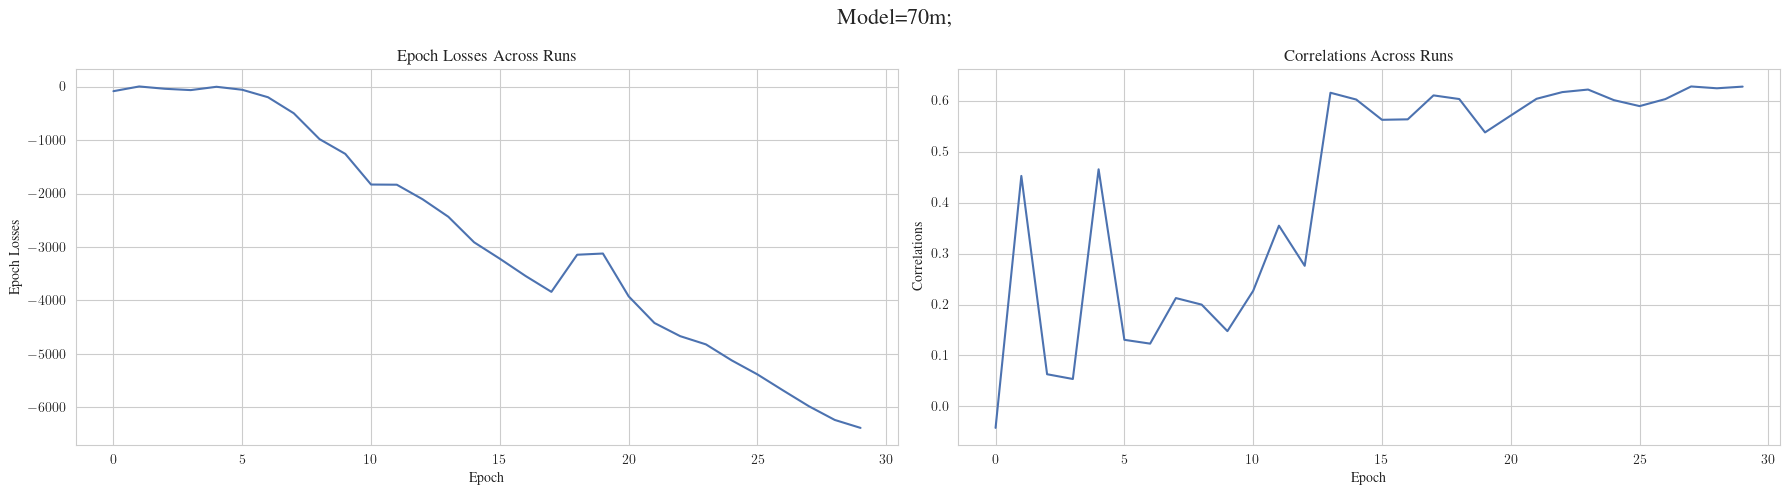

'results/irl/loss_corr/results_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier__30_epochs_lr_0.0001_jaredjoss-jigsaw-long-2000_70m_ss_100_oriCorr_0.628.json'

In [26]:
# best performing run
error_bars_plot(analysis_df.iloc[0]['path'], setting=None, ylim=None)
analysis_df.iloc[0]['path']

# Naive RIRL

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## 70m

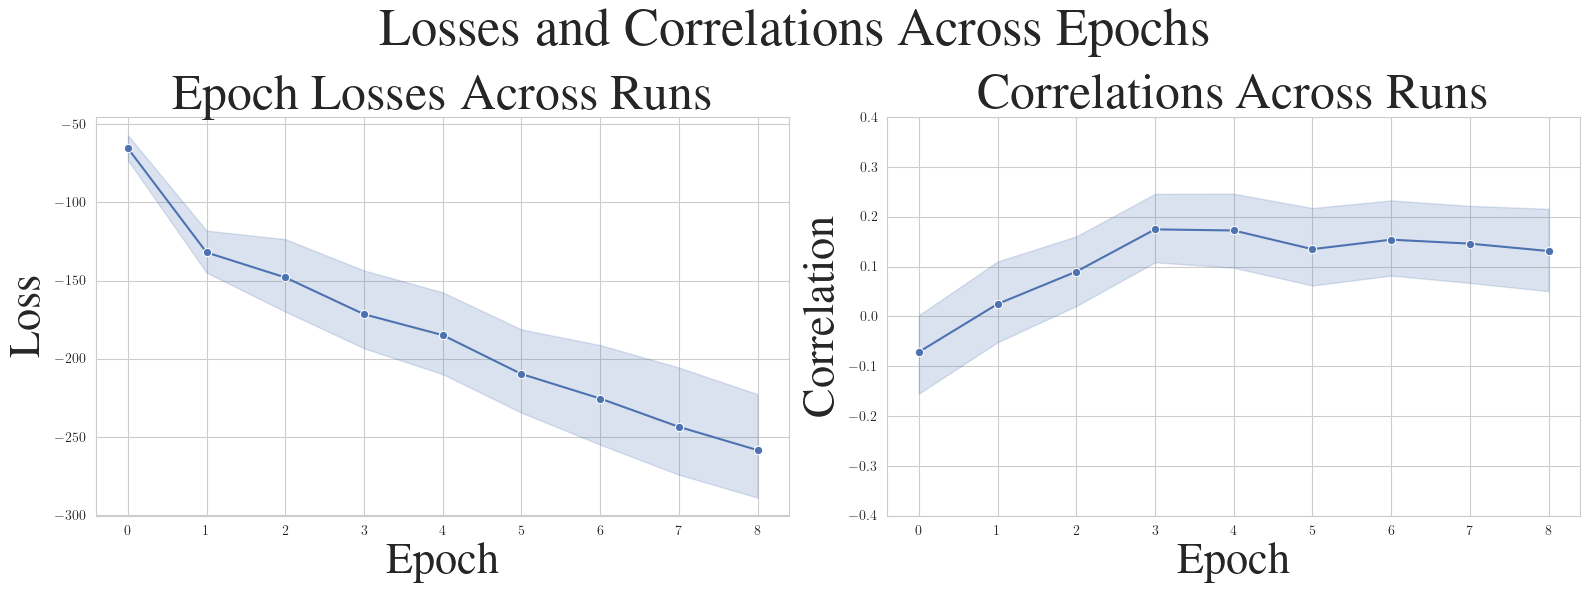

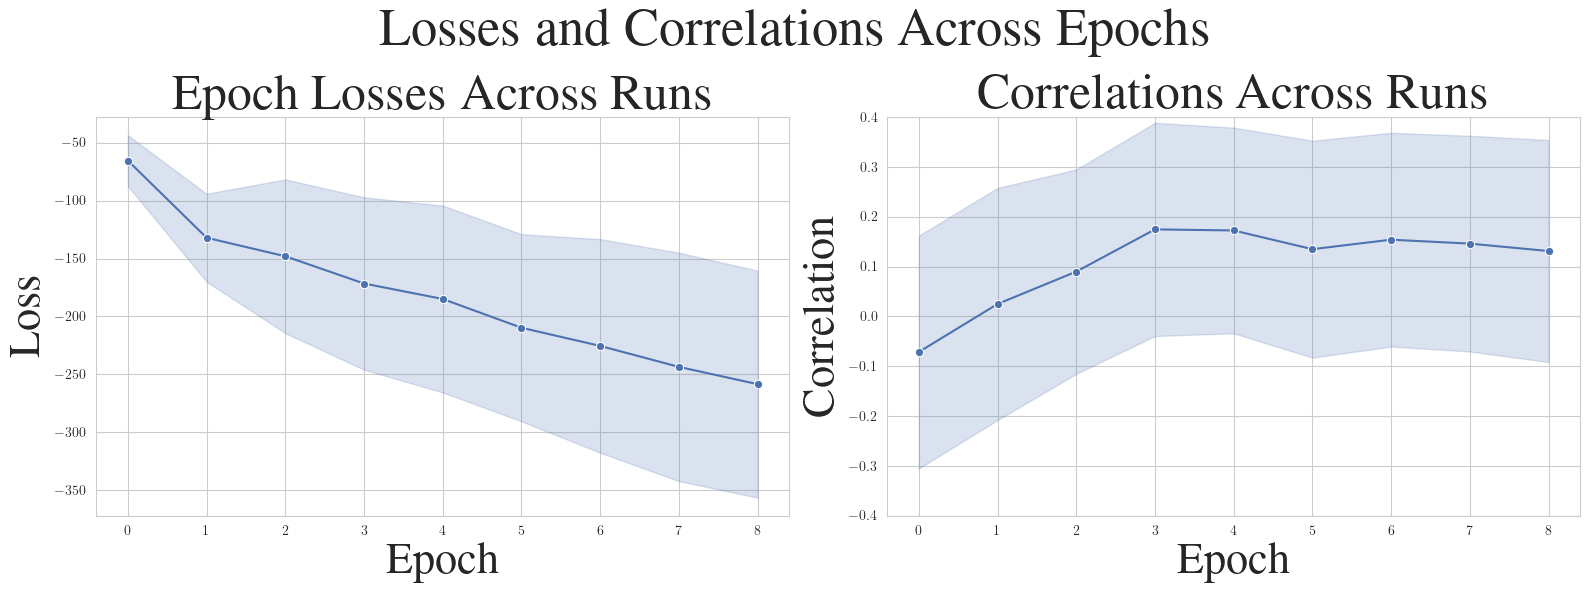

In [202]:
# 9 epochs, 30 reps
df = pd.read_json('results/irl/rirl/results_9_epochs_lr_0.0001_jaredjoss-jigsaw-long-2000_70m_ss_100_Oricorr_0.48.json')#.iloc[0].to_frame().T

error_bars_plot_multi(df, ylim=(-0.4, 0.4), setting='ci')
error_bars_plot_multi(df, ylim=(-0.4, 0.4), setting='sd')

In [203]:
df

,all_epoch_losses,all_correlations
0,"[-67.27238164138794, -160.92738067626954, -187...","[-0.046196834059367003, -0.019316449625615, -0..."
1,"[-40.4555382604599, -133.0113688659668, -174.4...","[-0.26786601113109404, -0.142965717695817, -0...."
2,"[-53.720118228197094, -151.9143115234375, -188...","[-0.342655666539324, -0.28116196609529504, -0...."
3,"[-93.15712876796722, -168.1039559326172, -197....","[-0.040686652630416, 0.025874672972924003, 0.4..."
4,"[-75.23673381996154, -29.151150634765624, -0.4...","[0.001469372103474, 0.283201445639551, 0.26101..."
5,"[-86.35752251338958, -119.61763061523438, 13.9...","[-0.25391990839627004, 0.48365228400450605, 0...."
6,"[-74.20747750854493, -106.8490736694336, -145....","[-0.143559989922036, 0.056183331527361005, -0...."
7,"[-34.47375779056549, -132.8162035217285, -164....","[-0.27916835938941403, -0.05232789226587101, 0..."
8,"[-81.2364004573822, -166.16581964111327, -191....","[0.090701893459128, 0.43818241116821205, 0.172..."
9,"[-50.28779164886475, -150.33571353149415, -179...","[-0.135502373282681, -0.20147307646958001, 0.3..."


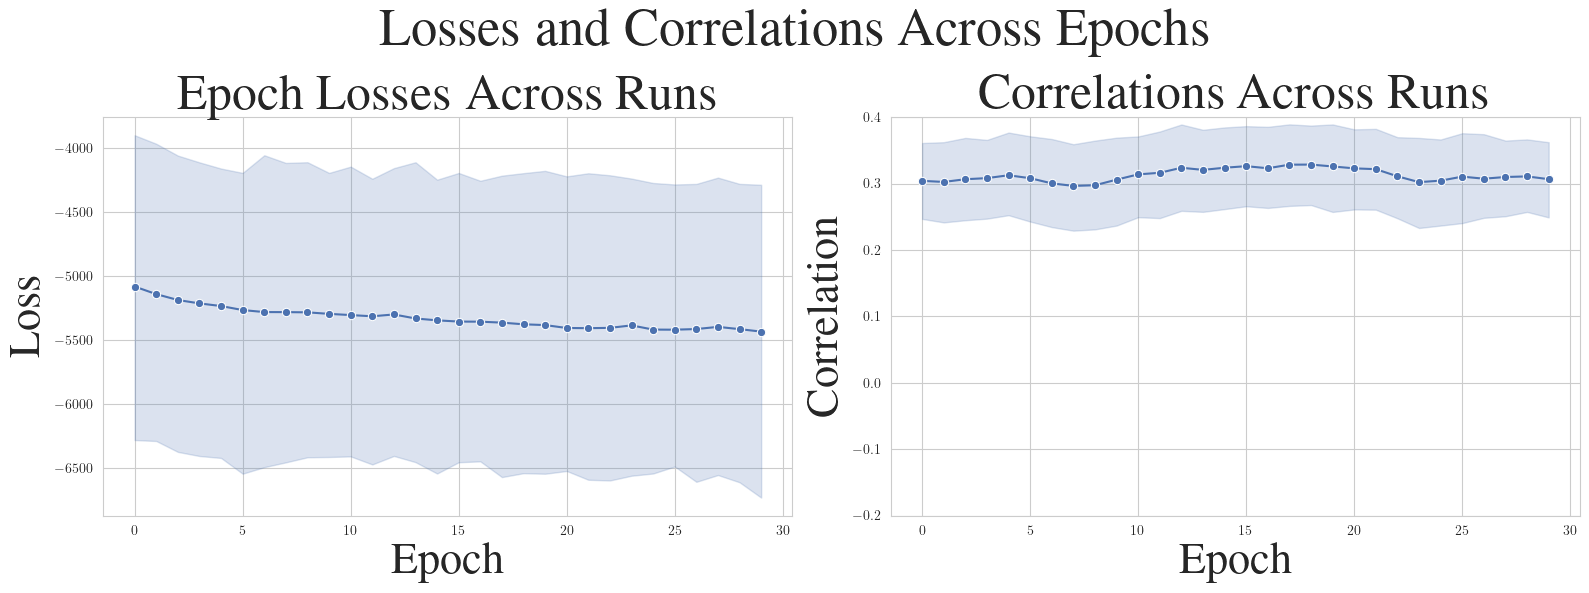

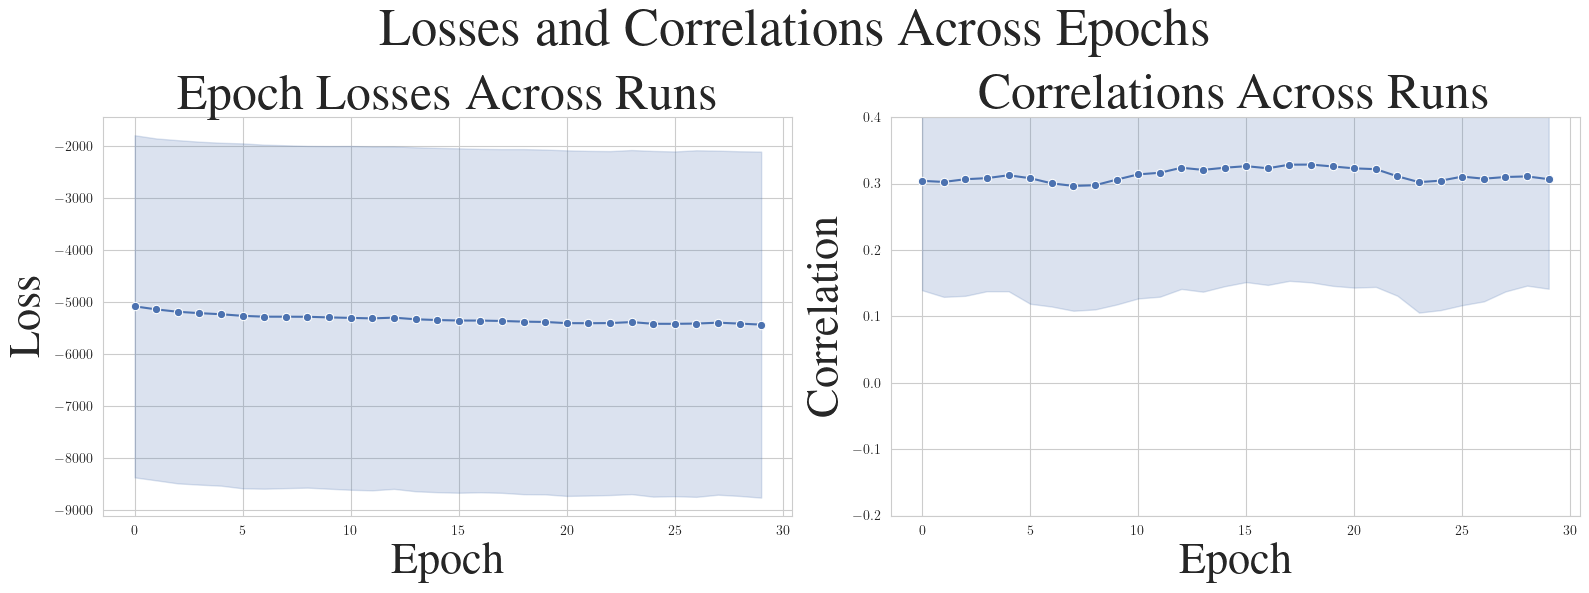

In [192]:
# 30 epochs, 30 reps
df = pd.read_json('results/irl/rirl/results_30_epochs_lr_5e-06_jaredjoss-jigsaw-long-2000_70m_ss_100.json')#.iloc[0].to_frame().T

error_bars_plot_multi(df, ylim=(-0.2, 0.4), setting='ci')
error_bars_plot_multi(df, ylim=(-0.2, 0.4), setting='sd')

## 410m

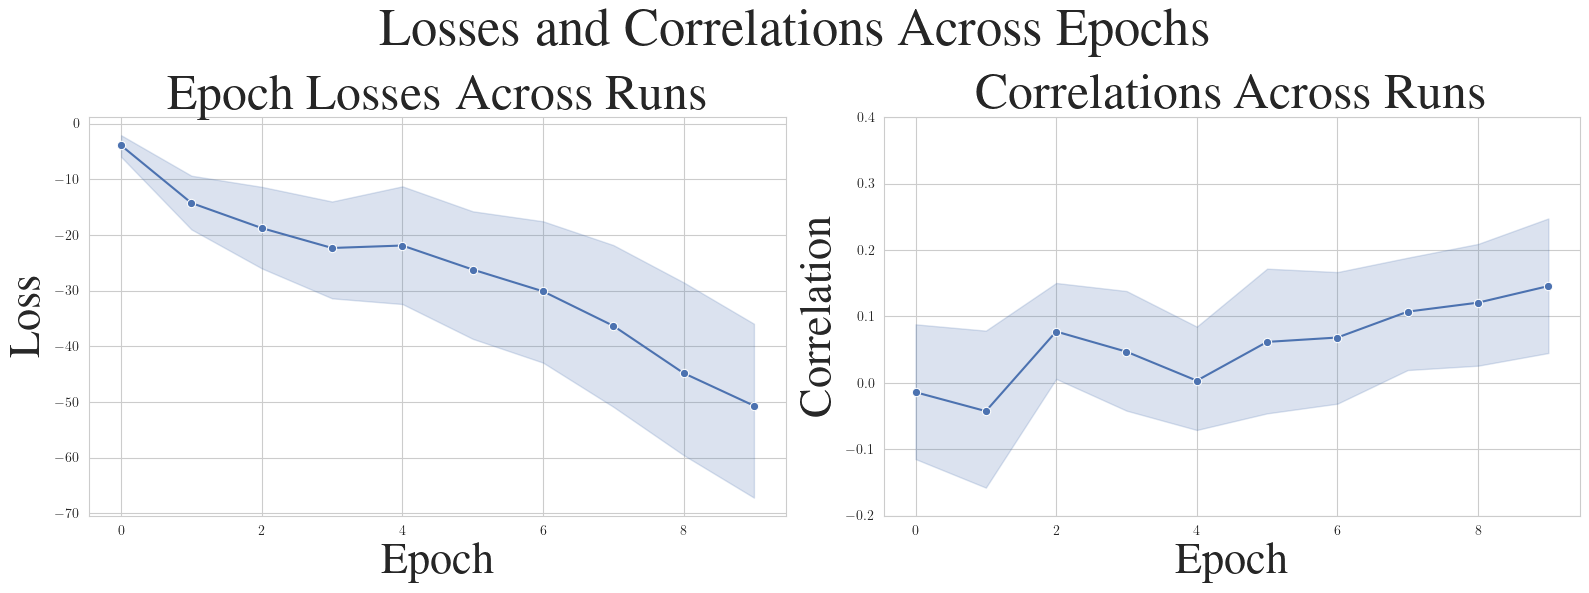

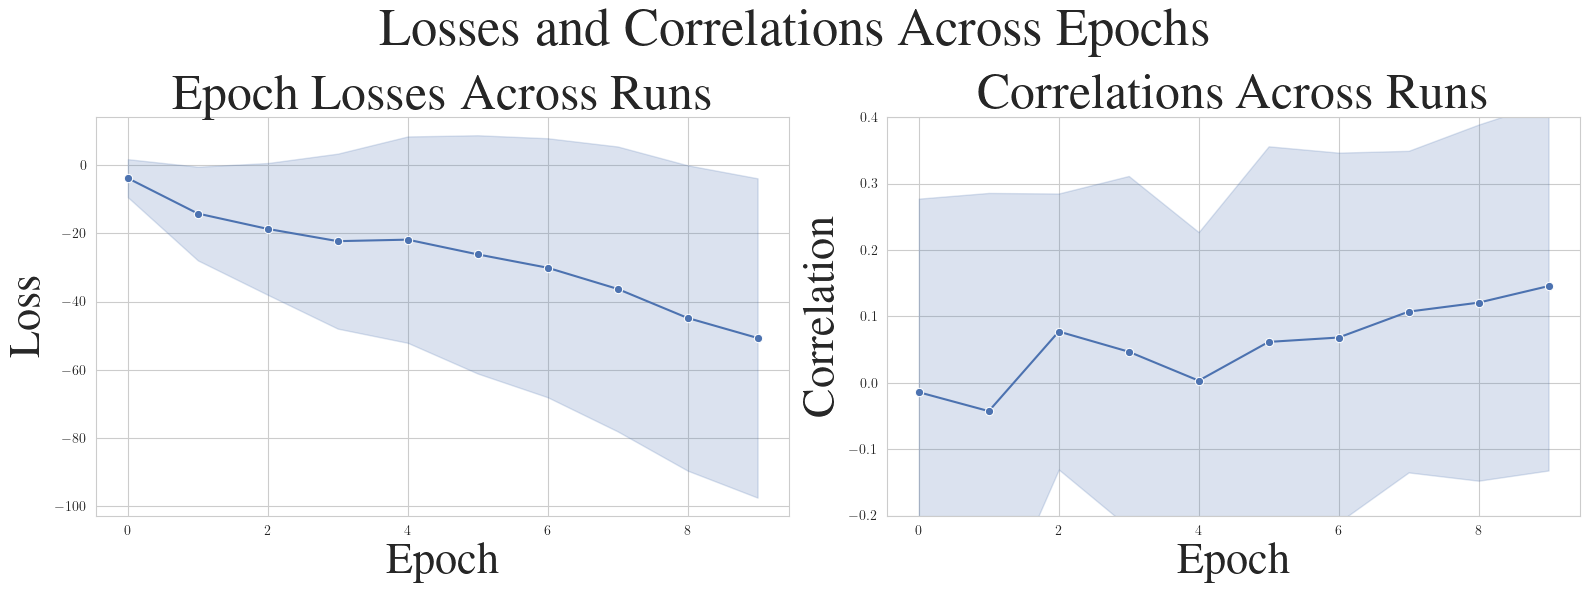

In [191]:
# 10 epochs, 30 reps
df = pd.read_json('results/irl/rirl/results_10_epochs_lr_1e-06_jaredjoss-jigsaw-long-2000_410m_ss_200.json')

error_bars_plot_multi(df, ylim=(-0.2, 0.4), setting='ci')
error_bars_plot_multi(df, ylim=(-0.2, 0.4), setting='sd')

# RIRL V2

## Single Epsilon

Number of runs: 2


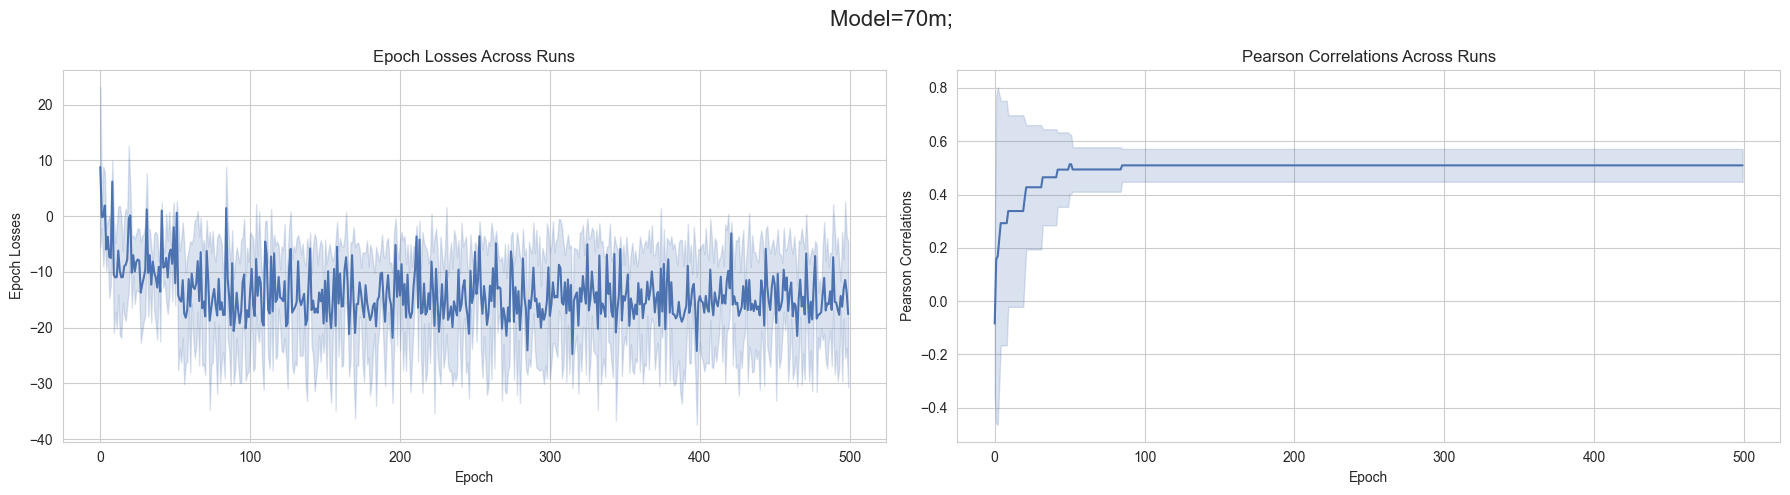

In [180]:
pattern = 'results/irl/rirl_v2/results_*lr_0.0001_jaredjoss-jigsaw-long-2000_*pythia-70m_ss_100_eps_0_corr_*.json'

error_bars_plot(pattern, setting='sd', ylim=None, metrics=['epoch_losses', 'pearson_correlations'], )

## Multi Epsilon

Number of runs: 10


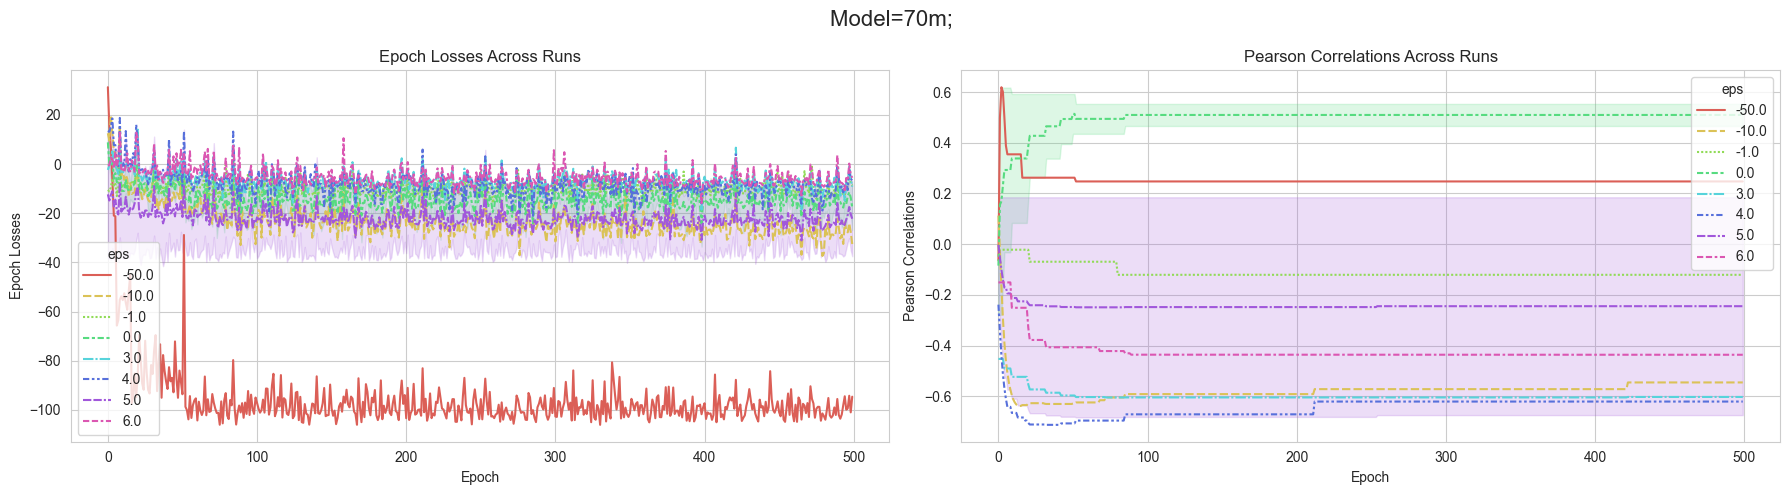

In [181]:
pattern = 'results/irl/rirl_v2/results_*lr_0.0001_jaredjoss-jigsaw-long-2000_*pythia-70m_ss_100_eps_*_corr_*.json'

error_bars_comparison_plot(pattern, epochs=500, setting='ci', param='eps', metrics=['epoch_losses', 'pearson_correlations'])